# Tag Calculator
This notebook calculates the different unequal splits for each of the splitters given a code length and SAW filter insertion loss.

### Basic Tag Diagram
![Basic Tag Diagram](Tag-Diagram.png "Basic Tag Diagram")
This image shows a tag with a code length of 4.

**Approach**

For the nth tap, the signal needs to flow through $n-1$ filters, each of which introduce loss. If the loss is expressed as a ratio $r$ (not in dB), then the signal power required to obtain an output with power $s$ is: $$\frac{s}{r^{n-1}} = sr^{-n+1}$$
The total input signal power is the sum of the required powers to drive each tap, or $$\sum_{n=1}^{t}sr^{-n+1} = sr\sum_{n=1}^{t}(\frac{1}{r})^{n} = s\frac{1-(\frac{1}{r})^{t}}{1-(\frac{1}{r})} = s\frac{r-(\frac{1}{r})^{(t-1)}}{r-1}$$ where $t$ is the total number of taps. If the total input power is 1, then s, the power output of each tap, is: $$s=\frac{r-1}{r-(\frac{1}{r})^{(t-1)}}$$


In [1]:
import tabulate
import numpy as np

In [2]:
# Inputs
inst_code_length = 8
inst_insertion_loss = 1.2 #dB
frequency = 433.9e6

In [3]:
def calc_splitters(code_length, insertion_loss):
    r = 10**-(insertion_loss/10)
     #The calculation from above
    power_per_tap = (r-1)/(r-(1/r)**(code_length-1))

    #For each splitter, calculate s parameters and output powers
    input_power = 1
    data = np.zeros((code_length-1, 5))
    
    for filter in range(code_length-1):
        data[filter][3] = input_power - power_per_tap #Power going into the next filter
        data[filter][4] = power_per_tap               #Power going out of this tap to the transmit antenna
        data[filter][2] = data[filter][4]/input_power #S31
        data[filter][1] = data[filter][3]/input_power #S21
        data[filter][0] = filter                      #Filter IDX
        input_power = data[filter][3] * 10**-(insertion_loss/10) #loss from the next filter    

    return data

In [4]:
splitter_data = calc_splitters(inst_code_length, inst_insertion_loss)
splitter_table_headers = ["Splitter", "S21", "S31", "Power (P2)", "Power (P3)"]
splitter_table = tabulate.tabulate(splitter_data, splitter_table_headers, tablefmt='html')
splitter_table

Splitter,S21,S31,Power (P2),Power (P3)
0,0.960806,0.0391937,0.960806,0.0391937
1,0.946225,0.0537749,0.689652,0.0391937
2,0.925082,0.0749179,0.483961,0.0391937
3,0.893241,0.106759,0.327929,0.0391937
4,0.842443,0.157557,0.209566,0.0391937
5,0.753455,0.246545,0.119778,0.0391937
6,0.568641,0.431359,0.0516673,0.0391937


## Impedance Calculations
From https://www.microwaves101.com/calculators/871-unequal-split-power-divider-calculator:
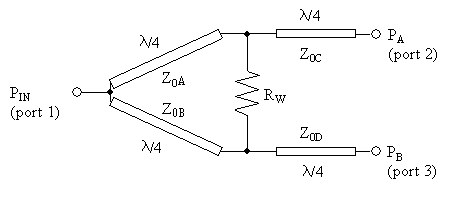

In [5]:
def calc_impedance(Z_0, P_A, P_B):
    r = P_A/P_B
    Z_0A = Z_0*(r**-1.5+r**-0.5)**0.5
    Z_0B = Z_0*(1+r)**0.5*r**0.25
    Z_0C = Z_0*r**-0.25
    Z_0D = Z_0*r**0.25
    R_W = Z_0*(r**0.5+r**-0.5)
    return [Z_0A, Z_0B, Z_0C, Z_0D, R_W]

Using these component labels:
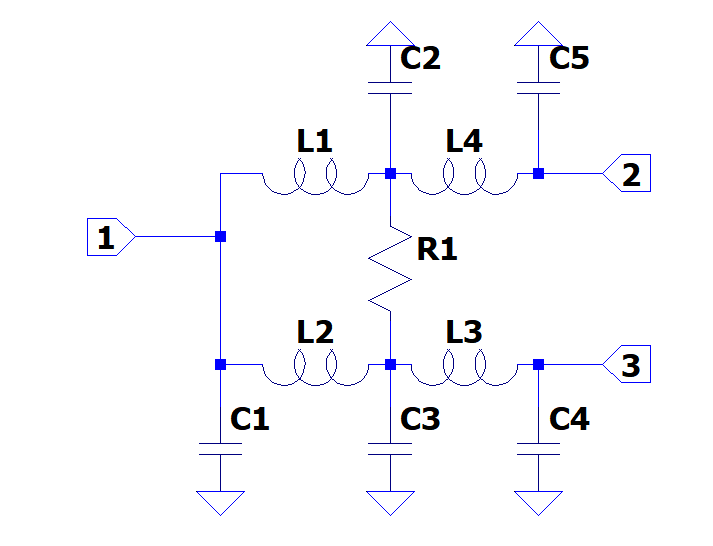

In [6]:
def calc_values(impedances, f_c):
    Z_0A = impedances[0]
    Z_0B = impedances[1]
    Z_0C = impedances[2]
    Z_0D = impedances[3]
    R_W = impedances[4]
    #Order: R1, C1, C2, C3, C4, C5, L1, L2, L3, L4
    L1 = Z_0A/(2 * np.pi * f_c) * 10e9
    L2 = Z_0B/(2 * np.pi * f_c) * 10e9
    L3 = Z_0D/(2 * np.pi * f_c) * 10e9
    L4 = Z_0C/(2 * np.pi * f_c) * 10e9
    C4 = 1/(Z_0D * 2 * np.pi * f_c) * 10e12
    C5 = 1/(Z_0C * 2 * np.pi * f_c) * 10e12
    C1 = 1/(Z_0A * 2 * np.pi * f_c) + 1/(Z_0B * 2 * np.pi * f_c) * 10e12
    C2 = 1/(Z_0A * 2 * np.pi * f_c) + 1/(Z_0C * 2 * np.pi * f_c) * 10e12
    C3 = 1/(Z_0B * 2 * np.pi * f_c) + 1/(Z_0D * 2 * np.pi * f_c) * 10e12
    return [R_W, C1, C2, C3, C4, C5, L1, L2, L3, L4]

In [7]:
#Make a table for every splitter
values = np.zeros((len(splitter_data), 11))
for s_idx in range(len(splitter_data)):
    impedances = calc_impedance(50, splitter_data[s_idx][3], splitter_data[s_idx][4])
    values[s_idx] = np.concatenate(([s_idx], calc_values(impedances, frequency)))
    
values = values
value_table_headers = ["Splitter", "R0 (Ω)", "C1 (pF)", "C2 (pF)", "C3 (pF)", "C4 (pF)", "C5 (pF)", 
                       "L1 (nH)", "L2 (nH)", "L3 (nH)", "L4 (nH)"]
value_table = tabulate.tabulate(values, value_table_headers, tablefmt='html')
value_table

Splitter,R0 (Ω),C1 (pF),C2 (pF),C3 (pF),C4 (pF),C5 (pF),L1 (nH),L2 (nH),L3 (nH),L4 (nH)
0,257.658,6.527,163.236,32.969,32.969,163.236,84.0867,2061.33,408.09,82.4224
1,221.658,8.30609,150.25,35.8185,35.8185,150.25,92.0555,1619.81,375.625,89.5461
2,189.927,10.7116,137.518,39.1347,39.1347,137.518,101.721,1256.05,343.795,97.8367
3,161.914,14.0936,124.767,43.134,43.134,124.767,114.097,954.638,311.919,107.835
4,137.24,19.1493,111.554,48.243,48.243,111.554,131.403,702.6,278.886,120.608
5,116.009,27.5498,96.9953,55.4843,55.4843,96.9953,159.802,488.363,242.488,138.711
6,100.956,44.9655,78.6069,68.4637,68.4637,78.6069,226.977,299.214,196.517,171.159
